## Table of Contents
1. [Preprocess data](#preprocess_data)
2. [Load Data](#load_data)
3. [Merge](#merge)
4. [EDA](#eda)
5. [How accurate is FORECAST_DEMAND?](#how_accurate_is_forecast_demand)
6. [Forecast and Actual Demand over Time](#)
7. [Forecast Demand over Time](#)
8. [Total Demand over Time](#)
9. [Temperature Over Time](#)
10. []()

In [1]:
import pandas as pd
from pandas.tseries.offsets import CustomBusinessDay
import numpy as np
import os
import matplotlib.pyplot as plt
import functools
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.graphics.tsaplots as tsa
import plotly.express as px
from utils import csv_to_parquet, month_to_season
from utils import plot_correlation_heatmap

In [2]:
class CFG:
    wandb_project_name = 'electricity_demand_forecasting'
    wandb_run_name = 'xgboost'
    data_path = './../data/NSW'
    images_path = './../images/xgb'
    models_path = './../trained_models'
    train = False  # True for train, False for inference
    logging = False  # set to True to enable W&B logging
    img_dim1 = 20
    img_dim2 = 10

In [3]:
plt.style.use('fivethirtyeight')
plt.rcParams.update({'figure.figsize': (CFG.img_dim1, CFG.img_dim2)})

<a id="preprocess_data"></a>
# Preprocess Data
Parquet files are smaller than CSV, faster to read, and retain the specified index column. Parquet is becoming a more accepted standard and is used in data warehousing applications like RedShift. For these reasons, we're converting the project data files to parquet as the first step. 

First the function checks to see if the parquet files exist. If the parquet already exists, the function will skip. If the parquet files do not exist, the function will perform the conversion

In [4]:
!../script.sh  # unzip csv files

/bin/bash: line 1: ../script.sh: No such file or directory


In [5]:
csv_to_parquet(
    csv_folder=CFG.data_path, 
    parquet_folder=CFG.data_path
)  # convert csv to parquet if not exists

Parquet file for forecastdemand_nsw.csv exists. Skipping conversion...
Parquet file for temperature_nsw.csv exists. Skipping conversion...
Parquet file for totaldemand_nsw.csv exists. Skipping conversion...
Parquet file for price_cleaned_data.csv exists. Skipping conversion...


# load data
forecast demand

In [6]:
nsw_forecastdemand = pd.read_parquet(
    os.path.join(CFG.data_path, 'forecastdemand_nsw.parquet'),
).groupby('DATETIME').agg({'FORECASTDEMAND': 'mean'})

total demand

In [7]:
nsw_totaldemand = pd.read_parquet(
    os.path.join(CFG.data_path, 'totaldemand_nsw.parquet'),
)

temperature

In [8]:
nsw_temperature = pd.read_parquet(
    os.path.join(CFG.data_path, 'temperature_nsw.parquet'),
).resample('30min').mean()
nsw_temperature['TEMPERATURE'] = nsw_temperature['TEMPERATURE'].interpolate(method='time')

price

In [9]:
price_df = pd.read_parquet(
    os.path.join(CFG.data_path, 'price_cleaned_data.parquet'), 
)
price_df['rrp'] = price_df['rrp'].interpolate(method='time')

# merge

In [10]:
dfs = [
    nsw_totaldemand, 
    nsw_forecastdemand, 
    nsw_temperature, 
    price_df
]

nsw_df = functools.reduce(
    lambda left, right: 
    pd.merge(
        left, 
        right, 
        left_index=True, 
        right_index=True, 
        how='inner'
    ), dfs
)

# EDA

In [11]:
nsw_df.describe()

,TOTALDEMAND,FORECASTDEMAND,TEMPERATURE,rrp
count,196512.000000,196512.000000,196512.000000,196512.000000
mean,8113.146242,8107.153035,17.528241,56.878814
std,1299.536070,1303.190137,5.877381,158.199128
min,5074.630000,4878.596667,-1.300000,-264.310000
25%,7150.067500,7129.623620,13.500000,31.430000
50%,8053.230000,8061.563409,17.900000,47.720000
75%,8958.550000,8965.041462,21.500000,63.930000
max,14579.860000,14601.171964,44.700000,14700.000000


In [12]:
nsw_df.corr()

,TOTALDEMAND,FORECASTDEMAND,TEMPERATURE,rrp
TOTALDEMAND,1.000000,0.987169,0.148978,0.122342
FORECASTDEMAND,0.987169,1.000000,0.144837,0.114135
TEMPERATURE,0.148978,0.144837,1.000000,0.056842
rrp,0.122342,0.114135,0.056842,1.000000


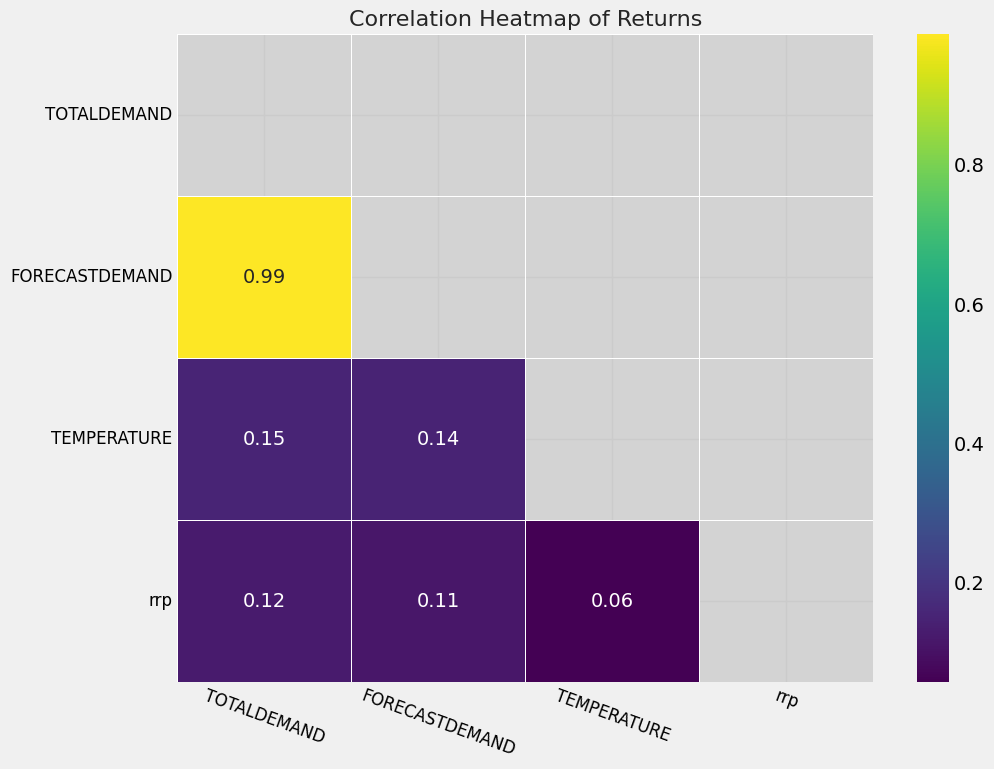

In [13]:
plot_correlation_heatmap(nsw_df)

# How accurate is FORECAST_DEMAND (the benchmark)?
the dataset includes a FORECAST_DEMAND feature, which is calculated by AEMO. It is useful to consider how accurate this forecast is compared to the actual TOTALDEMAND. This will help us understand the quality of the current forecast, provide a benchmark for evaluating the performance of any models we build, and insights into how to beat the existing forecast.

In [14]:
# calc absolute differences
absolute_differences = np.abs(nsw_df['TOTALDEMAND'] - nsw_df['FORECASTDEMAND'])

In [15]:
# calc MAE
mae = absolute_differences.mean()

In [16]:
print(f"Mean Absolute Error (MAE): {mae}")

Mean Absolute Error (MAE): 150.6324555686905


So, a better forecast means achieving an MAE <= 150

# Forecast and actual demand over time

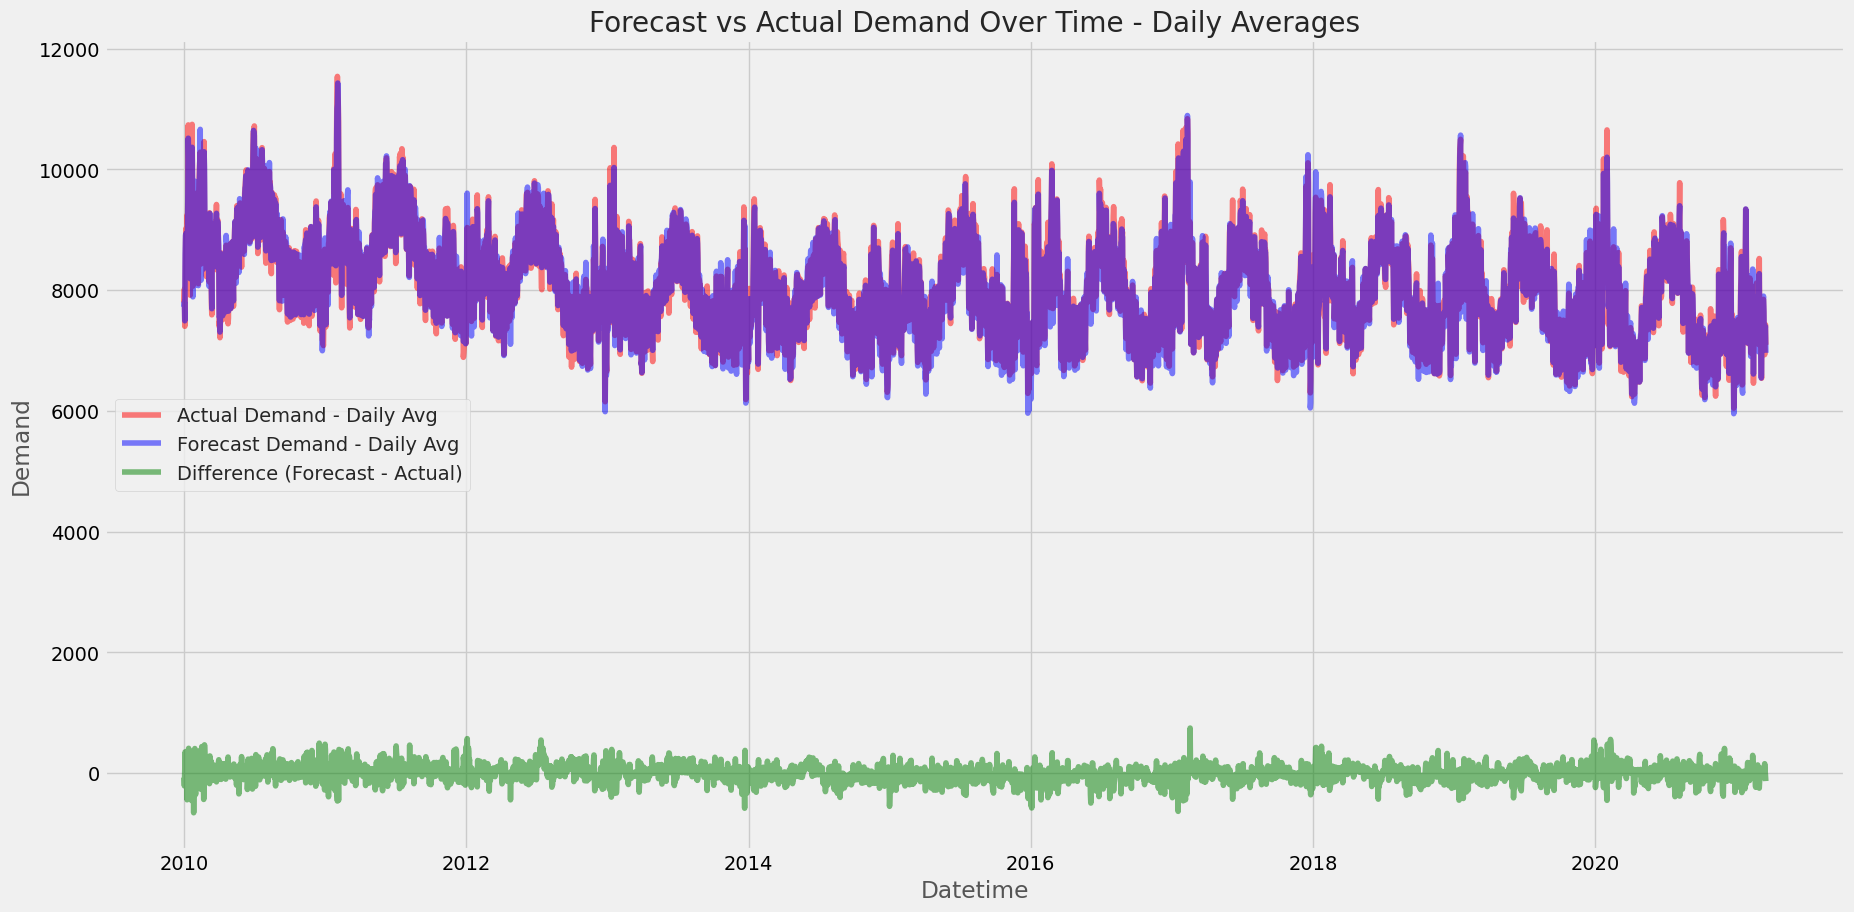

In [17]:
daily_avg_actual = nsw_df['TOTALDEMAND'].resample('D').mean()
daily_avg_forecast = nsw_df['FORECASTDEMAND'].resample('D').mean()

plt.plot(
    daily_avg_actual.index, 
    daily_avg_actual, 
    label='Actual Demand - Daily Avg', 
    color='red', 
    alpha=0.5
)

plt.plot(
    daily_avg_forecast.index, 
    daily_avg_forecast, 
    label='Forecast Demand - Daily Avg', 
    color='blue', 
    alpha=0.5
)

plt.plot(
    daily_avg_forecast.index, 
    daily_avg_forecast - daily_avg_actual, 
    label='Difference (Forecast - Actual)', 
    color='green', 
    alpha=0.5
)

plt.xlabel('Datetime')
plt.ylabel('Demand')
plt.title('Forecast vs Actual Demand Over Time - Daily Averages')
plt.legend()
plt.show()

# Observations
Observations from this plot:

1. **Demand Fluctuations**: Both actual and forecasted demand exhibit significant fluctuations over time. This is not unusual in energy demand data. Electricity demand tends to be highly variable, exhibiting many and complex seasonalities.

2. **Forecast Accuracy**: There are periods where the forecast demand closely tracks the actual demand, indicated by the overlap of the blue (forecast) and red (actual) lines. This suggests good forecast accuracy during these times. The absolute value of forecast error, shown by the green line is relatively low, indicating that the existing forecast is quite good.

3. **Error Consistency**: The green line representing the forecast error (forecast - actual) is centered around zero and stays relatively constant in terms of its variance, which indicates that the forecasting model is relatively stable over the observed period. There is no obvious trend suggesting that the forecast error is increasing or decreasing over time.

4. **Error Spikes**: There are occasional spikes in forecast error, where the green line has peaks or troughs. These could indicate exceptional events or changes in patterns that were not captured by the forecasting model. This is an area where our model can potentially improve existing performance.

5. **Seasonal Patterns**: Without more context or a clear x-axis label indicating months, it's hard to tell if there's a seasonal pattern. However, there seems to be some regularity in the fluctuations, which could suggest a seasonal influence on both actual and forecasted demand.

6. **Anomaly Detection**: There are a few instances where the actual demand has sharp peaks that are not mirrored in the forecast demand. These outliers could be due to unusual or unanticipated events that caused a surge in demand.

7. **No Drastic Drifts**: The forecasting model does not appear to suffer from drift over time, as the forecast error does not show a long-term trend away from zero. 

8. **Scale of Error**: The scale of the difference (forecast error) is smaller compared to the actual and forecast demand, suggesting that while errors exist, they are not dominating the forecast.

9. **Potential for Optimization**: The areas where the forecast significantly deviates from the actual demand could be targeted for further model optimization to improve accuracy. These areas of error tend to be th peaks and troughs of demand.

10. **Timeframe**: The data spans over a decade, from around 2010 to beyond 2020, providing a long-term view of demand and forecasting performance. Given that the informational value of records degrades as they get older, its possible that we have too much data for short term energy forecasting.

This plot provides valuable information for us to understand the performance of the existing demand forecasting model over time, and where it could be further improved.

## Reindexing and Interpolation
To fill in the missing values in the daily average actual and forecast demand, we reindex the series to include all dates in the original dataset and then interpolate the missing values. This will help us have a complete time series for further analysis.

In [18]:
daily_avg_actual_reindexed = daily_avg_actual.reindex(nsw_df.index)
daily_avg_actual_interpolated = daily_avg_actual_reindexed.interpolate(method='time')
nsw_df['daily_avg_actual'] = daily_avg_actual_interpolated
# nsw_df['daily_avg_actual']

In [19]:
daily_avg_forecast_reindexed = daily_avg_forecast.reindex(nsw_df.index)
daily_avg_forecast = daily_avg_forecast_reindexed.interpolate(method='time')
nsw_df['daily_avg_forecast'] = daily_avg_forecast
# nsw_df['daily_avg_forecast']

# calculate average error
our first new feature to add to the dataframe will be the forecast error, which we calculate here

In [20]:
daily_avg_error = daily_avg_forecast - daily_avg_actual
daily_avg_error_reindexed = daily_avg_error.reindex(nsw_df.index)
daily_avg_error_filled = daily_avg_error_reindexed.interpolate(method='time')
nsw_df['forecast_error'] = daily_avg_error_filled

# Forecast Demand over time
our existing data is quite noisy so I will smooth it out by applying a rolling mean. This will help us see the underlying trends more clearly:

In [21]:
rolling_window = 48
nsw_df['smoothed_forecast_demand'] = nsw_df['FORECASTDEMAND'].rolling(window=rolling_window).mean()
index_range = nsw_df.index[:rolling_window]
nsw_df.loc[index_range, 'smoothed_forecast_demand'] = nsw_df['smoothed_forecast_demand'][rolling_window:].interpolate(method='time').head(rolling_window)
nsw_df_daily = nsw_df['FORECASTDEMAND'].resample('D').mean()

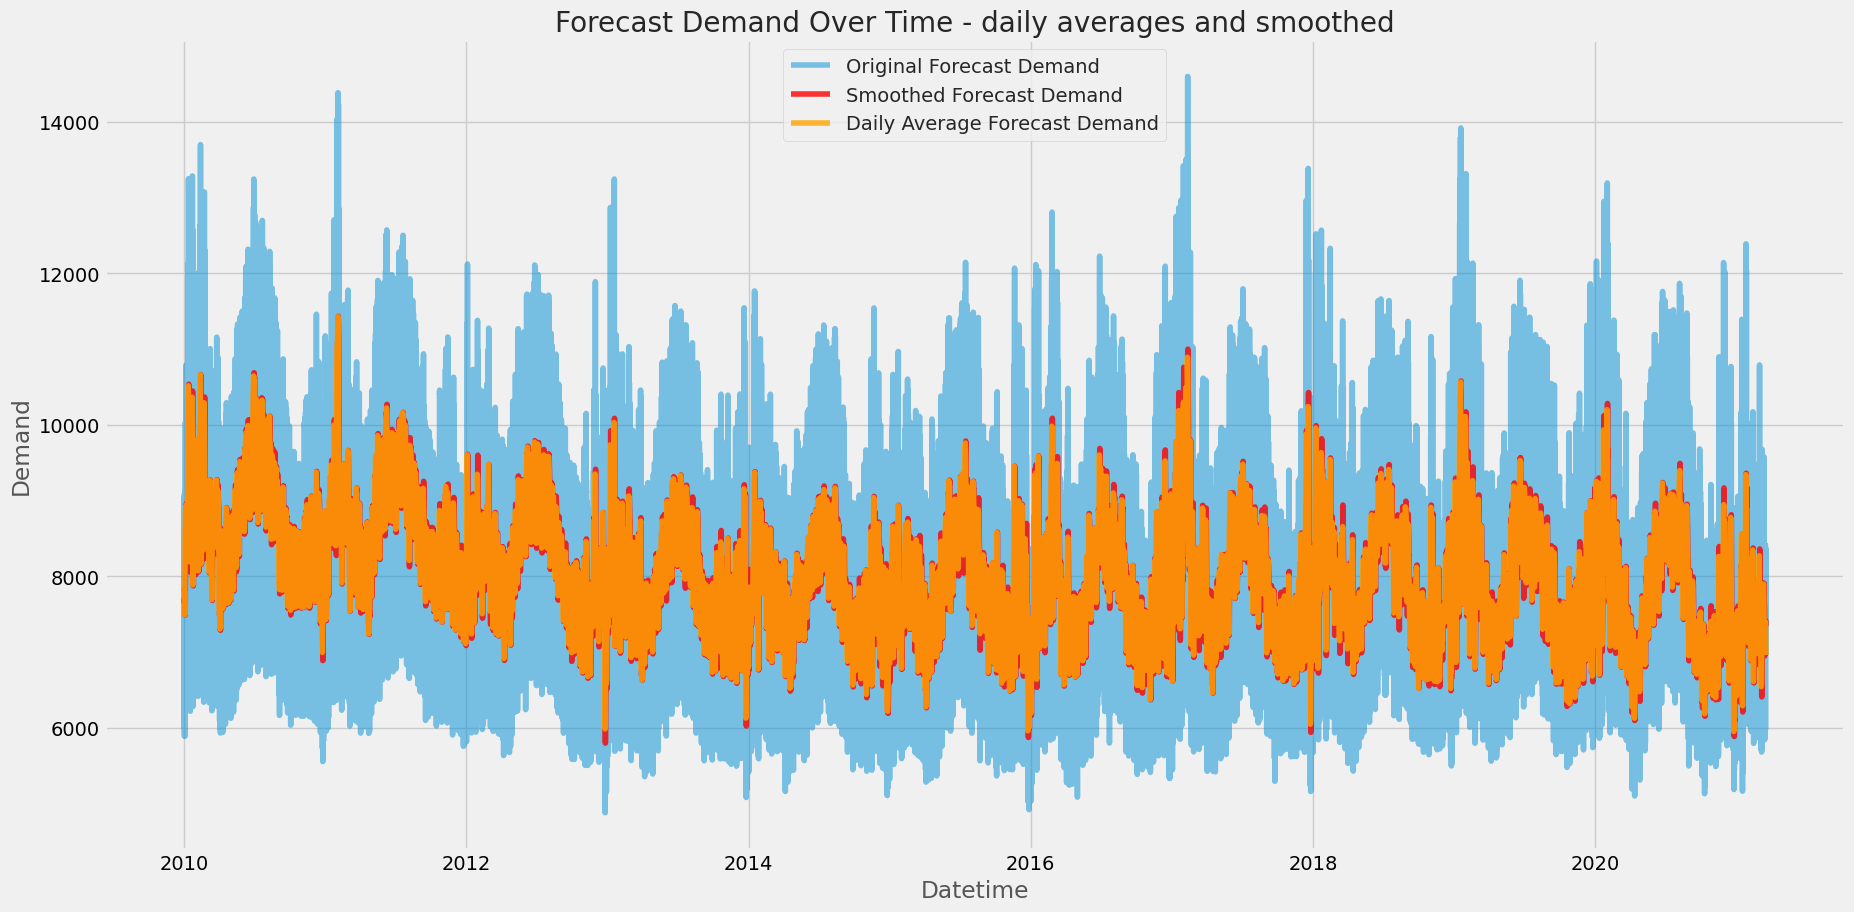

In [23]:
plt.plot(
    nsw_df['FORECASTDEMAND'], 
    label='Original Forecast Demand', 
    alpha=0.5
)
plt.plot(
    nsw_df['smoothed_forecast_demand'], 
    label='Smoothed Forecast Demand', 
    color='red', 
    alpha=0.8
)
plt.plot(
    nsw_df_daily.index, 
    nsw_df_daily, 
    label='Daily Average Forecast Demand', 
    color='orange', 
    alpha=0.8
)
plt.xlabel('Datetime')
plt.ylabel('Demand')
plt.title('Forecast Demand Over Time - daily averages and smoothed')
plt.grid(True)
plt.legend()
plt.show()

## Observations
The plot layers three time series: 
- the original forecast demand, 
- the smoothed forecast demand, 
- and the daily average forecast demand. 

Here are some potential conclusions and observations I draw from this plot:

1. **Volatility**: The original forecast demand shows significant volatility, as indicated by the frequent and sometimes sharp peaks and valleys.

2. **Smoothing Effect**: The smoothed forecast demand (the line in red) has reduced the short-term fluctuations, making the underlying trends more visible. It appears to follow the central tendency of the original forecast, reducing the impact of extreme values.

3. **Daily Patterns**: The daily average forecast demand (the line in yellow) simplifies the data to show the trend within each day, abstracting away the half-hourly variations. This line highlights the overall daily movement in demand without the noise of intra-day fluctuations.

4. **Long-term Trends**: Despite the daily and smoothed variations, there seems to be a consistent pattern that repeats over a longer cycle, perhaps weekly or seasonally, which would be worth investigating further.

5. **Comparative Analysis**: By overlaying the smoothed and daily averaged data over the original forecast demand, it's possible to compare short-term variations to longer-term patterns. This can be crucial for understanding both normal daily operations and the impact of specific events or anomalies.

6. **Anomaly Identification**: The points where the original demand significantly diverges from its smoothed or daily average counterpart may indicate anomalies or special events that caused unusual demand (such as holidays, heatwaves, etc.).

For further analysis, I should investigate the causes of the peaks and troughs in more detail, especially the outliers. For example, examining corresponding temperature data, special events, or other external factors could provide insights into why demand might spike or dip at various points in time.

# add new time-related columns directly to nsw_df
It is helpfult to engineer temporal (time) features from the original data to provide additional context and information for analysis and modeling. Here, I create several new columns based on the timestamp index, such as year, quarter, month, week of the year, day of the week, and more. These features can help capture seasonal patterns, trends, and other time-related dynamics in the data.

In [24]:
nsw_df['year'] = nsw_df.index.year
nsw_df['quarter'] = nsw_df.index.quarter
nsw_df['month'] = nsw_df.index.month
nsw_df['week_of_year'] = nsw_df.index.isocalendar().week
nsw_df['dow'] = nsw_df.index.dayofweek
nsw_df['doy'] = nsw_df.index.dayofyear
nsw_df['day_of_month'] = nsw_df.index.day
nsw_df['hour'] = nsw_df.index.hour
nsw_df['is_weekend'] = nsw_df.index.dayofweek > 4  # weekday vs weekend
nsw_df['part_of_day'] = pd.cut(nsw_df.index.hour, bins=[0, 6, 12, 18, 24], labels=['Night', 'Morning', 'Afternoon', 'Evening'], right=False)
nsw_df['season'] = nsw_df['month'].apply(month_to_season)

# create a custom business day calendar

In [25]:
cbd = CustomBusinessDay()


def is_business_day(date):
    """
    check if a date is a business day
    :param date: The date to be checked
    :return: bool, True if the date is a business day, False otherwise
    
    Example:
    >>> is_business_day(pd.Timestamp('2024-04-27'))
    False  # Assuming April 27, 2024, is a Saturday.
    """
    return date == (date + cbd) - cbd


nsw_df['is_business_day'] = nsw_df.index.map(is_business_day)  # apply the function
# nsw_df

# Smooth, plot & analyse TOTALDEMAND over Time
Lets repeat the same smoothing process to total demand and plot it to see if we can identify any patterns or trends

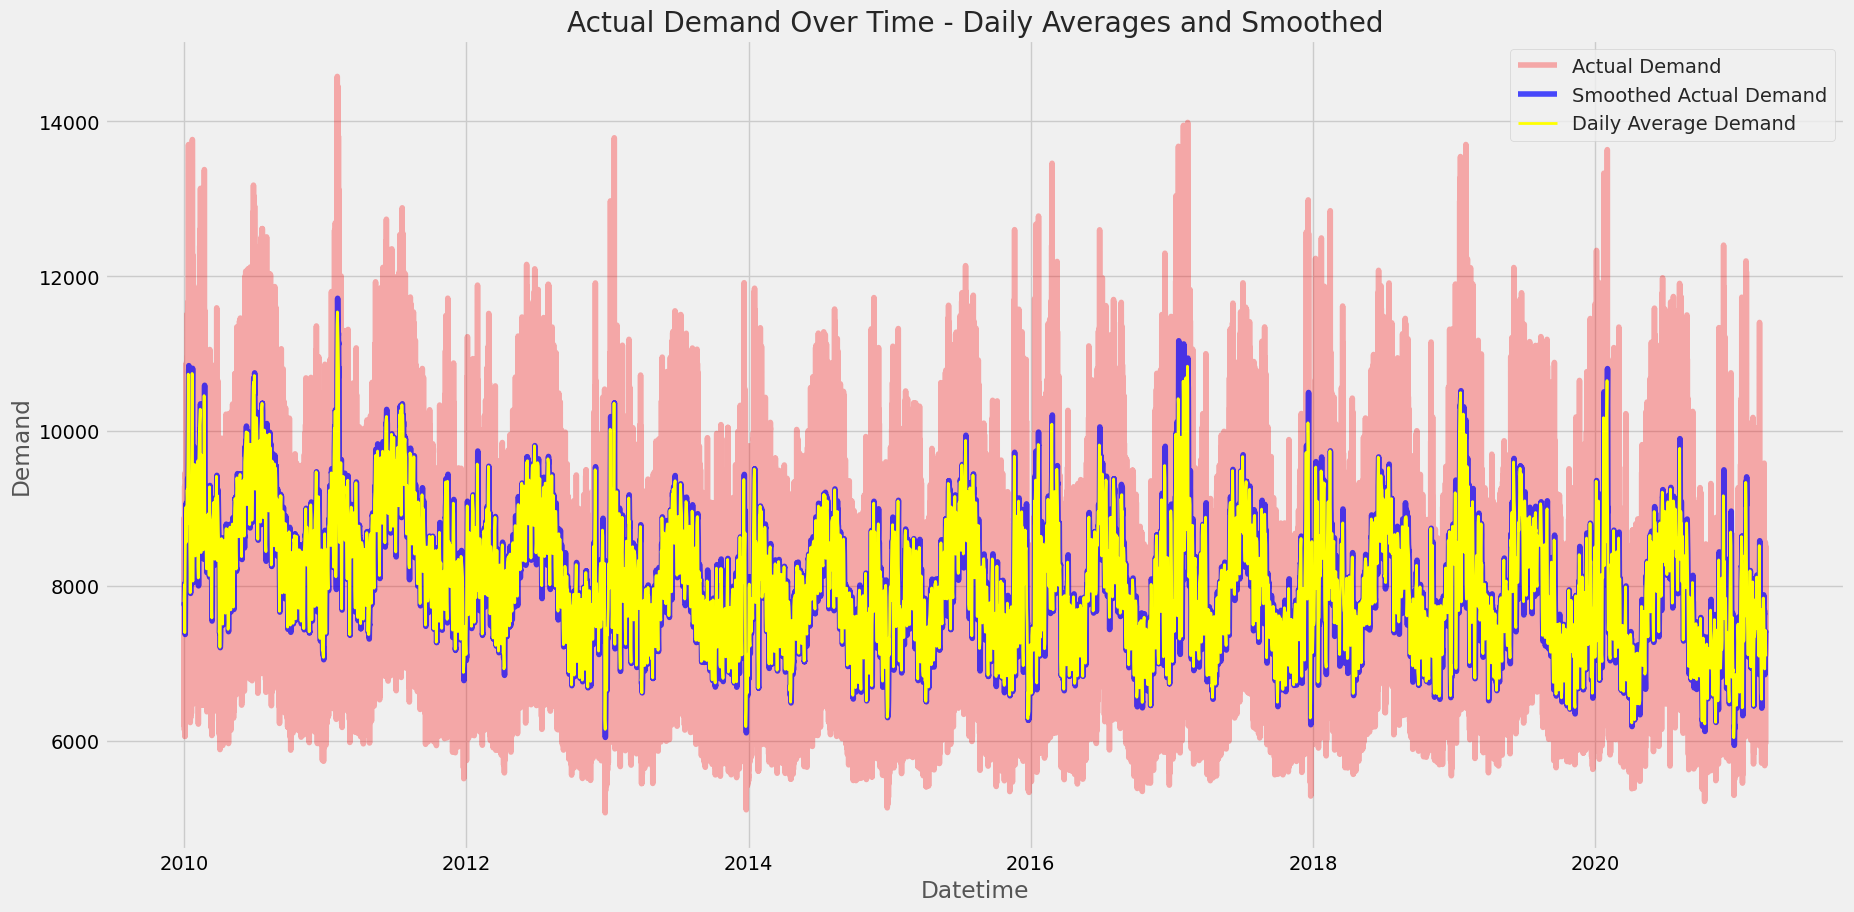

In [28]:
nsw_df_daily = nsw_df['TOTALDEMAND'].resample('D').mean()
rolling_window = 48
nsw_df['smoothed_total_demand'] = nsw_df['TOTALDEMAND'].rolling(window=rolling_window).mean()

plt.plot(
    nsw_df['TOTALDEMAND'], 
    label='Actual Demand', 
    color='red', 
    alpha=0.3
)

plt.plot(
    nsw_df.index, 
    nsw_df['smoothed_total_demand'], 
    label='Smoothed Actual Demand', 
    color='blue', 
    alpha=0.7
)

plt.plot(
    nsw_df_daily.index, 
    nsw_df_daily, 
    label='Daily Average Demand', 
    color='yellow', 
    alpha=1.0, 
    linewidth=2
)

plt.xlabel('Datetime')
plt.ylabel('Demand')
plt.title('Actual Demand Over Time - Daily Averages and Smoothed')

plt.grid(True)
plt.legend()
plt.show()

## Observations
This plot, which shows actual demand over time along with its daily average and smoothed version, include:

1. **Cyclical Patterns**: There are visible patterns that repeat over time, which may correspond to weekly, monthly, or seasonal cycles in electricity demand.

2. **Daily Variations**: The daily average demand (in yellow) shows how demand fluctuates on a day-to-day basis. This line smooths out the intraday variations and reveals the general movement of demand throughout the dataset's timeline.

3. **Trend Indication**: The smoothed actual demand (in blue) helps to identify the underlying trend by minimizing the impact of short-term fluctuations. This can provide insights into longer-term movements in demand, such as gradual increases or decreases over the years.

4. **Peak Demand Periods**: There are significant spikes in actual demand (in red) that stand out above the smoothed and daily average trends. These peaks could indicate days of particularly high demand, which could be due to extreme weather, special events, or other factors.

5. **Volatility**: The red peaks suggest periods of high volatility in actual demand. Understanding the factors contributing to this volatility could be crucial for grid management and planning.

6. **Data Density**: The plot is dense and hard to interpret in detail, particularly over such a long timeframe. A more granular view (e.g., looking at shorter periods) is likely provide more actionable insights. This should be the next task for me

7. **Anomalies and Outliers**: The actual demand has several outliers which are significantly different from the smoothed trend and daily average. These could represent data anomalies that may need to be investigated further.

To better understand the demand patterns and to make informed decisions, I should segment the data into different periods (such as by year, season, week and day), and analyse it in conjunction with other relevant data (like temperature or economic activity).

# Temperature over time
now lets do the same thing with temperature over time

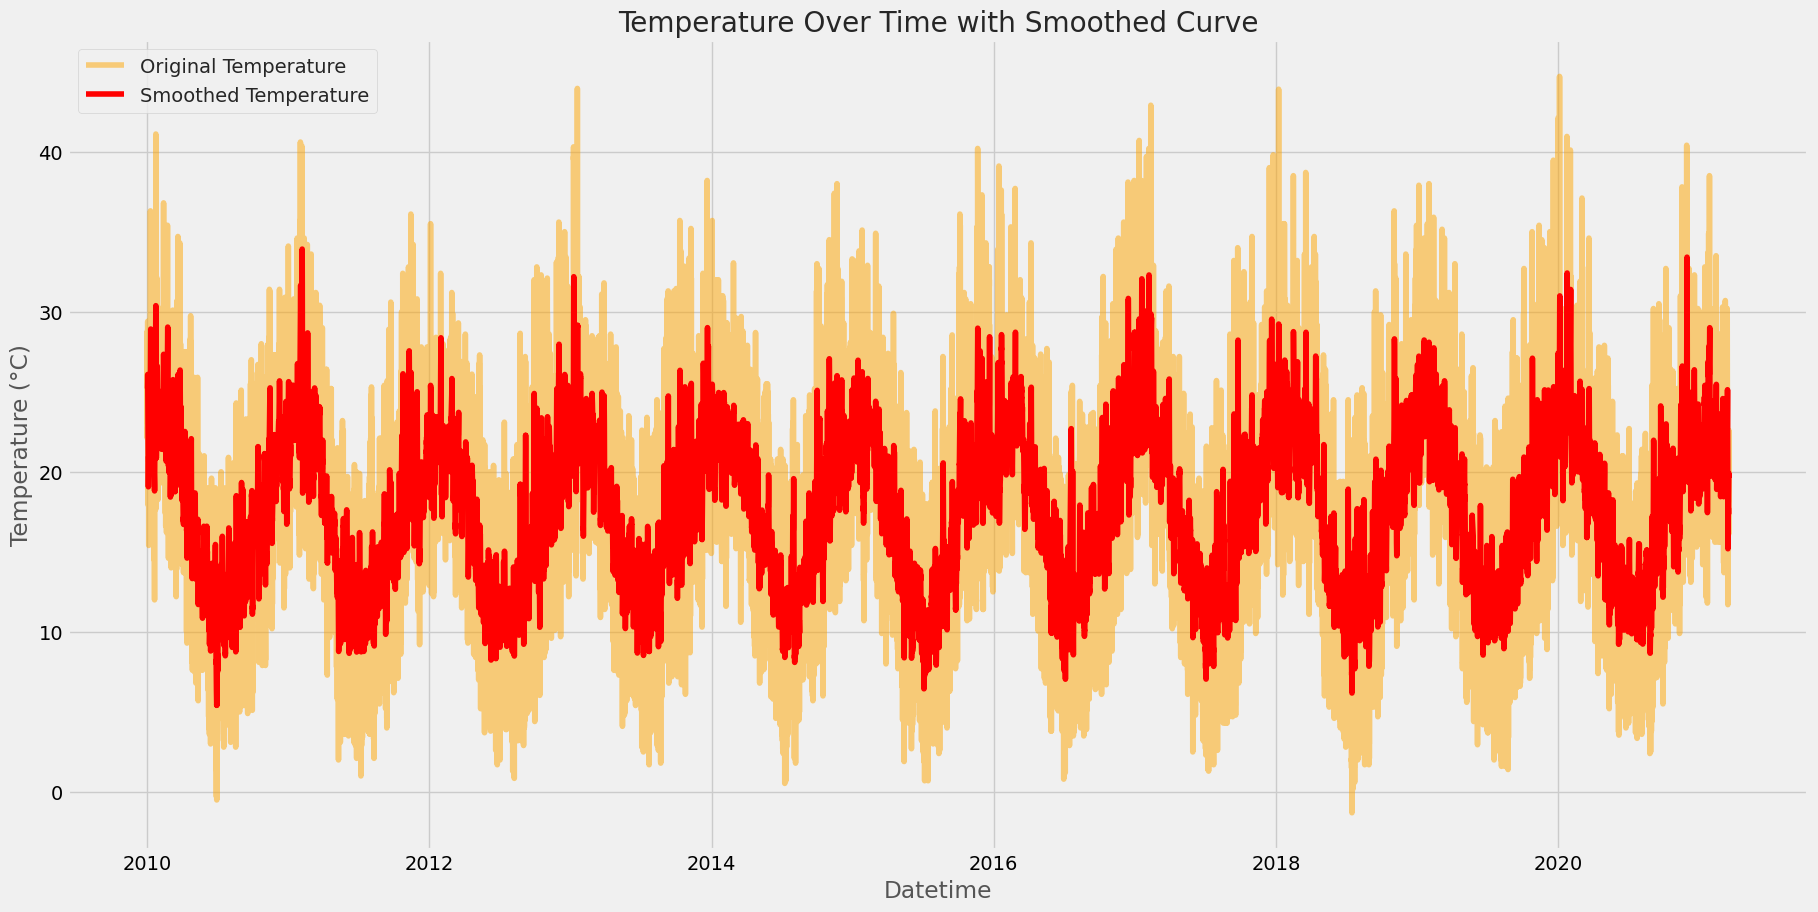

In [29]:
rolling_window = 48 
nsw_df['smoothed_temperature'] = nsw_df['TEMPERATURE'].rolling(window=rolling_window).mean()

# original temperature
plt.plot(
    nsw_df.index, 
    nsw_df['TEMPERATURE'], 
    color='orange', 
    alpha=0.5, 
    label='Original Temperature'
)

# smoothed temperature
plt.plot(
    nsw_df.index, 
    nsw_df['smoothed_temperature'], 
    color='red', 
    label='Smoothed Temperature'
)

plt.xlabel('Datetime')
plt.ylabel('Temperature (°C)')
plt.title('Temperature Over Time with Smoothed Curve')
plt.legend()
plt.show()

## Observations
In the provided plot, we observe the temperature data over time along with its smoothed counterpart:

1. **Original Temperature Data (Brown):** The original data shows significant variability over time with frequent spikes, which seasonal temperature changes. The data is quite noisy, with numerous peaks and troughs suggesting substantial short-term fluctuations, possibly due to short-term seasonalities, eg daily patterns in temperature.

2. **Smoothed Temperature (Red):** The smoothed curve dampens the noise and reveals the underlying trends more clearly. It follow a periodic pattern, which is indicative of seasonal variations in temperature—cooler in the middle of each year and warmer at the beginning and end.

3. **Seasonal Patterns:** There is a clear cyclical pattern that likely represents the change in seasons. The peaks of the smoothed curve likely represent the summer months, while the troughs represent the winter months. There appears to be multiple seasonalities in the data

4. **Trend Analysis:** There does not appear to be a significant long-term trend in the data, such as a consistent increase or decrease in temperatures over the years, which might be expected in the case of a warming climate. However, more detailed statistical analysis would be required to confirm this.

5. **Data Consistency:** The shape and pattern of the temperature fluctuations are consistent over the years, suggesting a stable seasonal cycle without drastic changes in temperature patterns during the recorded period.

6. **Potential Anomalies:** There are a few instances where the original temperature data shows very sharp spikes or drops. These could be days with unusual weather events.

7. **Practical Implications:** For applications such as energy demand forecasting, the smoothed temperature trend may be more useful. It indicates the general temperature pattern without the distraction of daily variability. Daily weekly and other temporal patterns are likely to be more useful for forecasting short term energy demand, so while we will add this feature, it will be intersting to see how much information it contributes to the model.

8. **Missing Data:** There do not appear to be any significant gaps in the data, suggesting that temperature readings are consistent and continuous over the time frame displayed.

# Scatter Plot: Temperature vs Demand
- to see if higher or lower temperatures correlate with higher or lower demand
- it looks like the line of best fit is quadratic to me

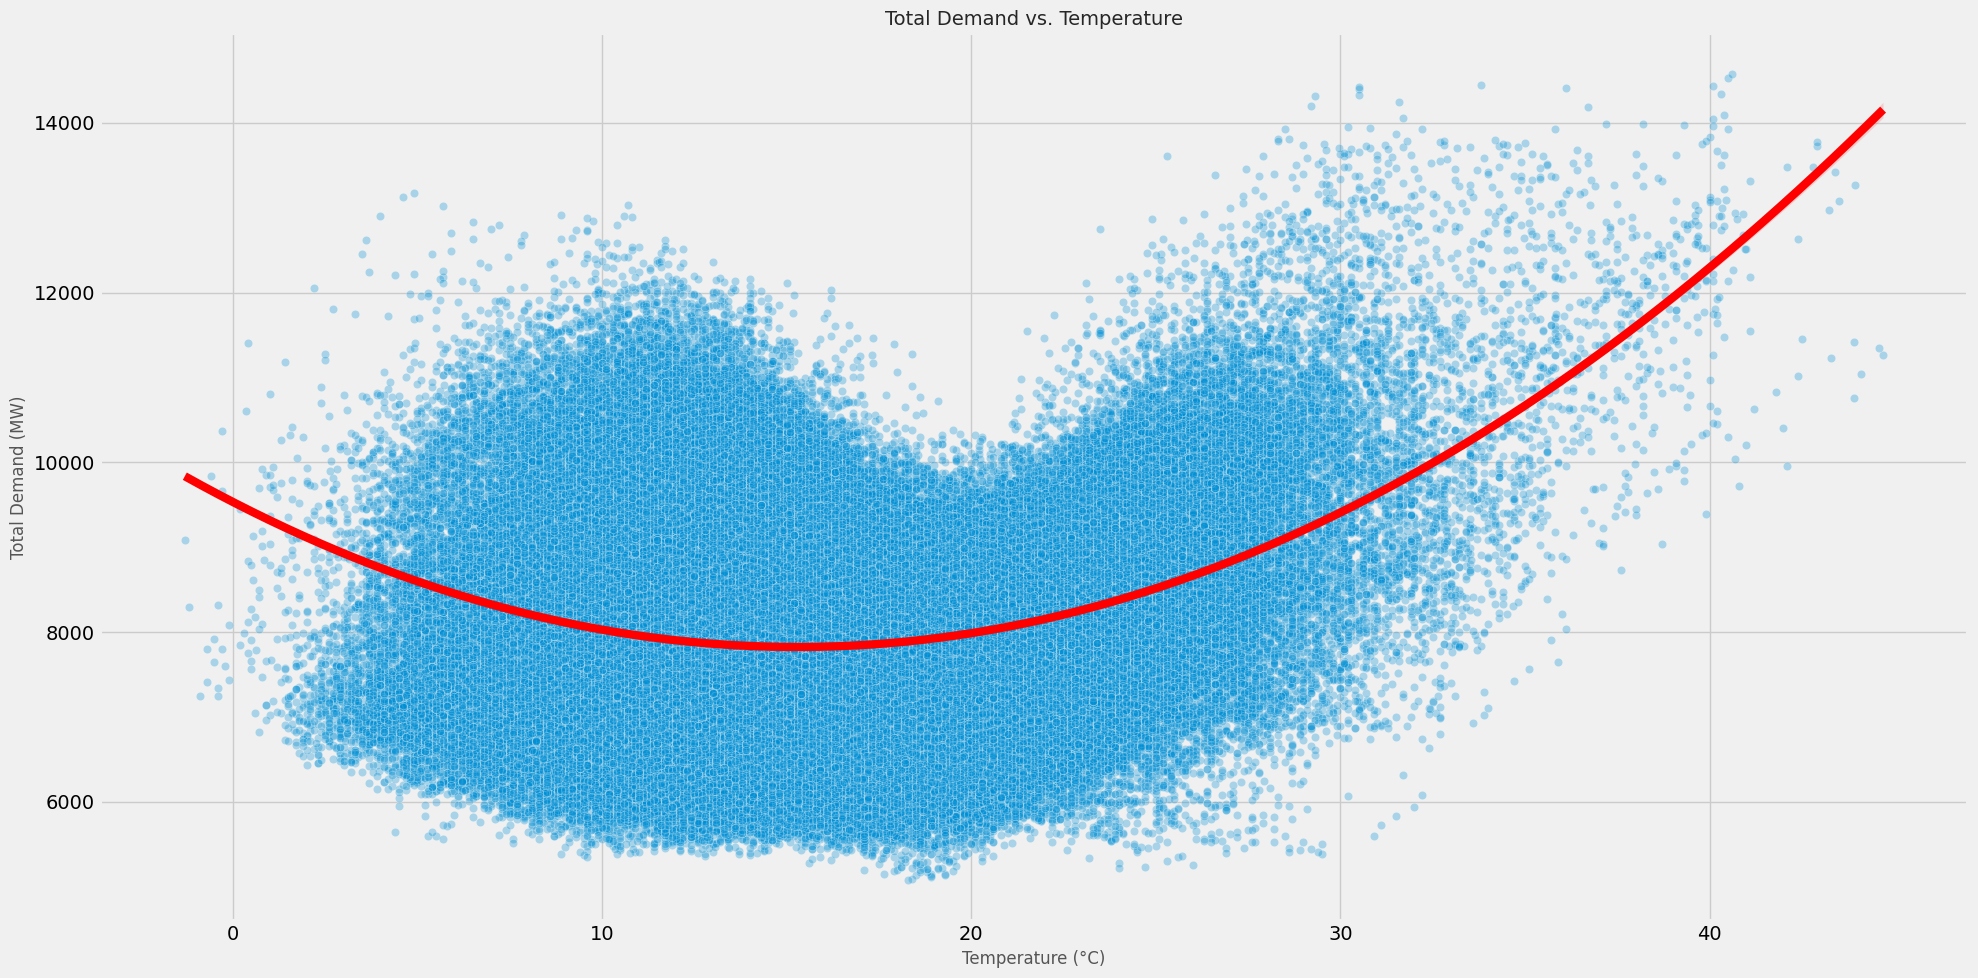

<Figure size 2000x1000 with 0 Axes>

In [30]:
# temperature vs total demand
sns.scatterplot(
    x='TEMPERATURE', 
    y='TOTALDEMAND', 
    data=nsw_df, 
    alpha=0.3
)

# fit and plot a polynomial regression with order 2 (quadratic)
sns.regplot(
    x='TEMPERATURE', 
    y='TOTALDEMAND', 
    data=nsw_df, 
    order=2, 
    scatter=False, 
    color='red'
)

plt.xlabel('Temperature (°C)', fontsize=12)
plt.ylabel('Total Demand (MW)', fontsize=12)
plt.title('Total Demand vs. Temperature', fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()
plt.savefig(os.path.join(CFG.images_path, 'total demand vs emperature.png'))

## Observations
The scatter plot shows Total Demand plotted against Temperature, with a quadratic trend line indicating the general pattern of the relationship between these two variables. Here are some observations we can infer from this plot:

1. **Non-linear Relationship**: There appears to be a non-linear, possibly quadratic relationship between temperature and total demand. Demand increases with temperature up to a certain point, after which it seems to plateau or even decline slightly.

2. **Increased Demand at Moderate Temperatures**: The highest total demand occurs at moderate temperatures, not at the extremes. This could indicate that the most energy-intensive activities (like heating and cooling) occur in a moderate temperature range.

3. **Lower Demand at Temperature Extremes**: There is a spread of demand at lower and higher temperatures, but the peaks are not as pronounced as in the moderate range. At low temperatures, this might mean adequate insulation or less need for electric heating. At high temperatures, it could imply that not all cooling is electric, or there may be a cap on how much cooling can be achieved.

4. **Possible Threshold Effect**: The trend line suggests that after a certain temperature threshold, increases in temperature do not result in significant increases in demand. This could be due to behavioral changes, energy-efficiency measures, or the saturation of cooling systems.

5. **Data Spread**: The considerable spread of data points at all temperature levels suggests that factors other than temperature also significantly influence total demand.

6. **High Variability**: There's significant variability in demand at specific temperatures, indicated by the vertical spread of points. This could be due to time-of-day effects, different days of the week, or other variables not accounted for in this two-dimensional plot.

In [31]:
# new feature
nsw_df['minutes_past_midnight'] = nsw_df.index.hour * 60 + nsw_df.index.minute

# Scatter plot: Total demand vs time of day (temp as color)
To visualize demand patterns at different times of the day.

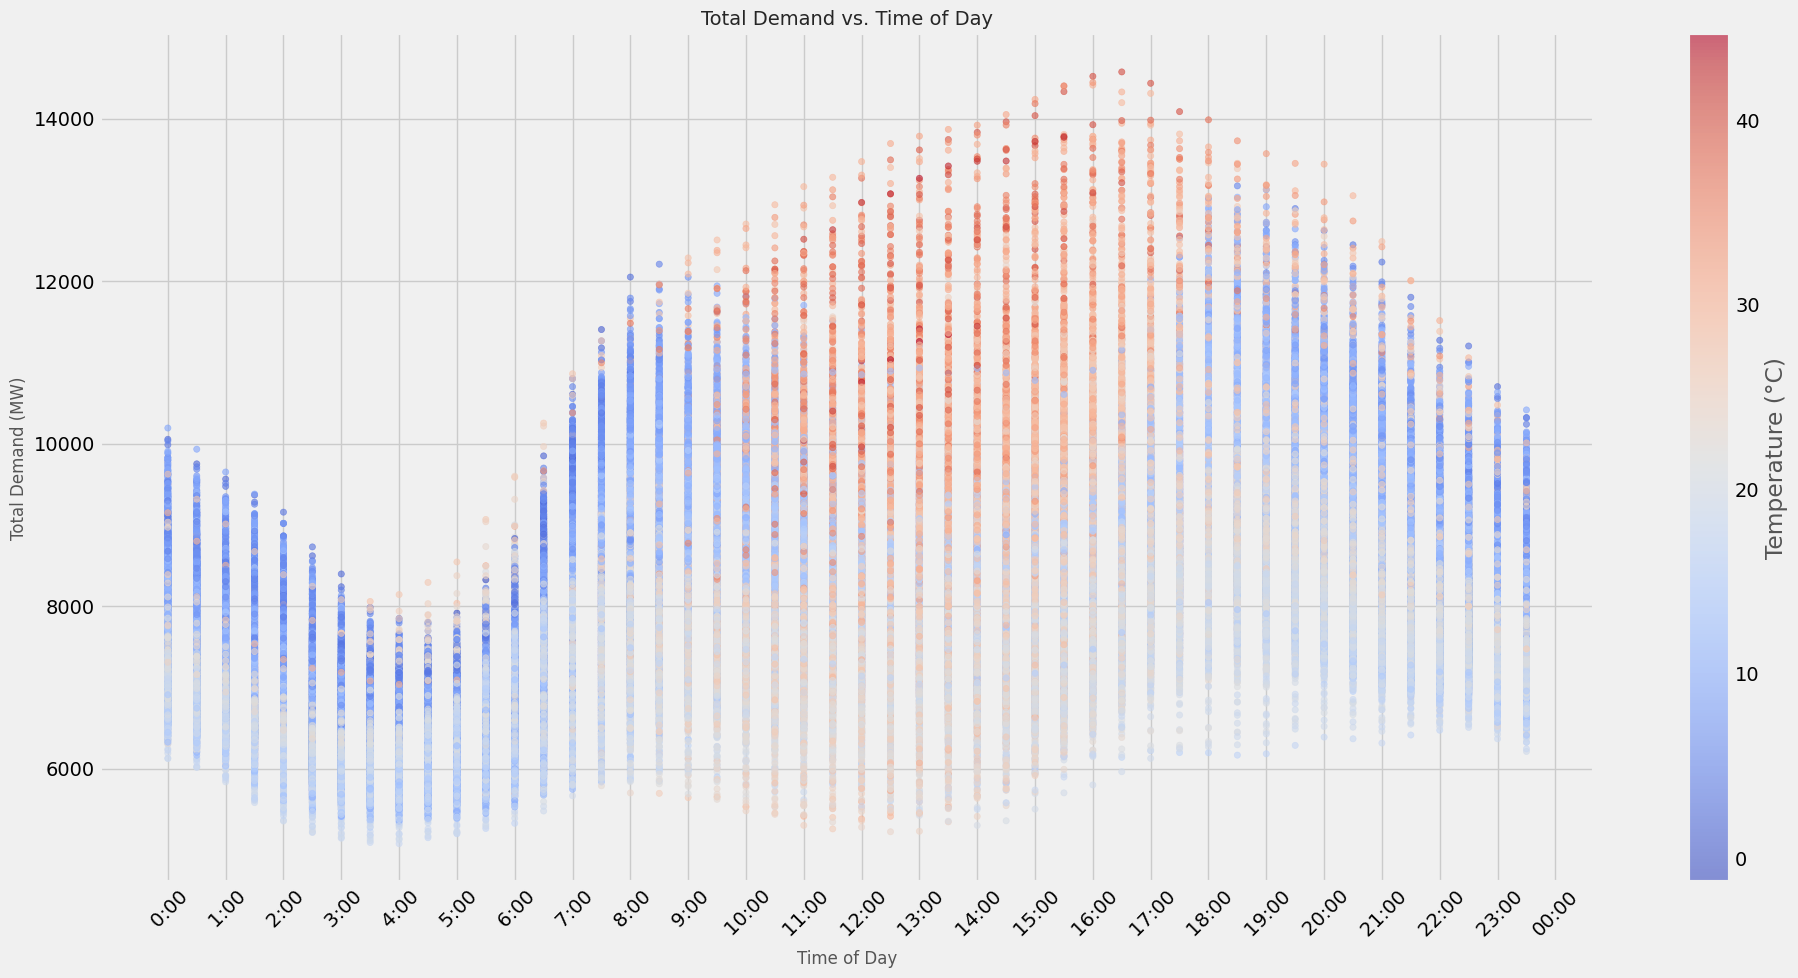

<Figure size 2000x1000 with 0 Axes>

In [32]:
# temperature, time and total demand
plt.scatter(
    nsw_df['minutes_past_midnight'], 
    nsw_df['TOTALDEMAND'], 
    c=nsw_df['TEMPERATURE'], 
    alpha=0.6, 
    cmap='coolwarm', 
    s=20
)  

plt.colorbar(label='Temperature (°C)')
plt.xlabel('Time of Day', fontsize=12)
plt.ylabel('Total Demand (MW)', fontsize=12)
plt.title('Total Demand vs. Time of Day', fontsize=14)
plt.grid(True)
tick_positions = range(0, 1441, 60)
tick_labels = [f'{h: 02d}:00' for h in range(24)] + ['00:00']
plt.xticks(ticks=tick_positions, labels=tick_labels, rotation=45)
plt.tight_layout()
plt.show()
plt.savefig(os.path.join(CFG.images_path, 'total demand vs time of day.png'))

## Observations
1. **Demand Peaks**: It appears that there are two distinct peaks in electricity demand, likely corresponding to morning and evening hours. This is a common pattern in electricity usage, often related to increased activity as people prepare for work and school, and then again as they come home and use more appliances.

2. **Temperature Influence**: The color gradient indicates a relationship between temperature and total demand. Warmer colors at higher demand levels could suggest higher energy usage during warmer temperatures, which might be due to air conditioning and cooling systems.

3. **Cooler Temperatures**: At cooler temperatures (blue points), demand seems less intense compared to warmer temperatures, which might indicate less energy usage for heating compared to cooling, or it could suggest that the data is from a region where cooling needs are greater than heating needs.

4. **Demand Troughs**: There are clear periods where demand is lower, likely during the night when most activities cease, and there's little need for lighting and appliances.

5. **Midday Patterns**: There's a visible increase in demand around midday, which could be due to usage in commercial buildings or by industrial processes.

6. **Temperature Variability**: There's a spread of temperature values across all times, but particularly so during the times of peak demand. This suggests that on days with higher temperatures, the peaks in demand might be more pronounced.

7. **Intraday Variability**: There's significant variability in demand at any given time, which could be influenced by various factors including but not limited to temperature, such as the day of the week, holidays, or specific events.

# Histogram: total demand distribution
to get an idea of the most common demand levels

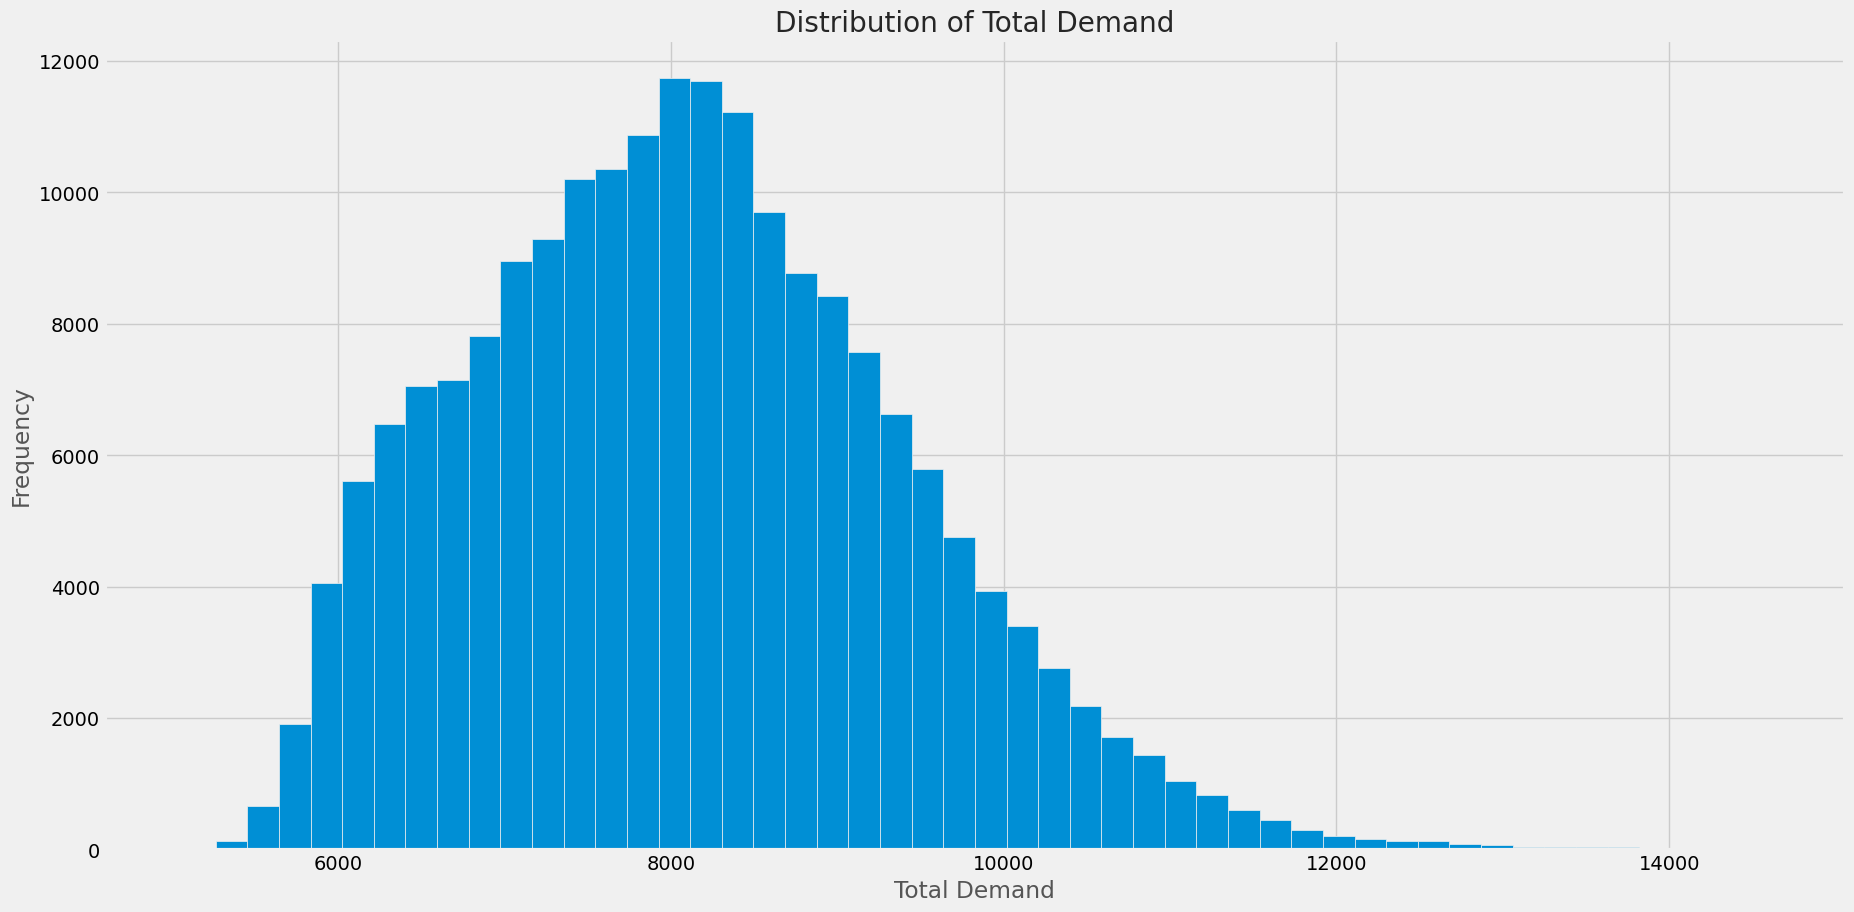

In [33]:
nsw_df['TOTALDEMAND'].hist(bins=50)
plt.xlabel('Total Demand')
plt.ylabel('Frequency')
plt.title('Distribution of Total Demand')
plt.show()

## Histogram: temperature distribution

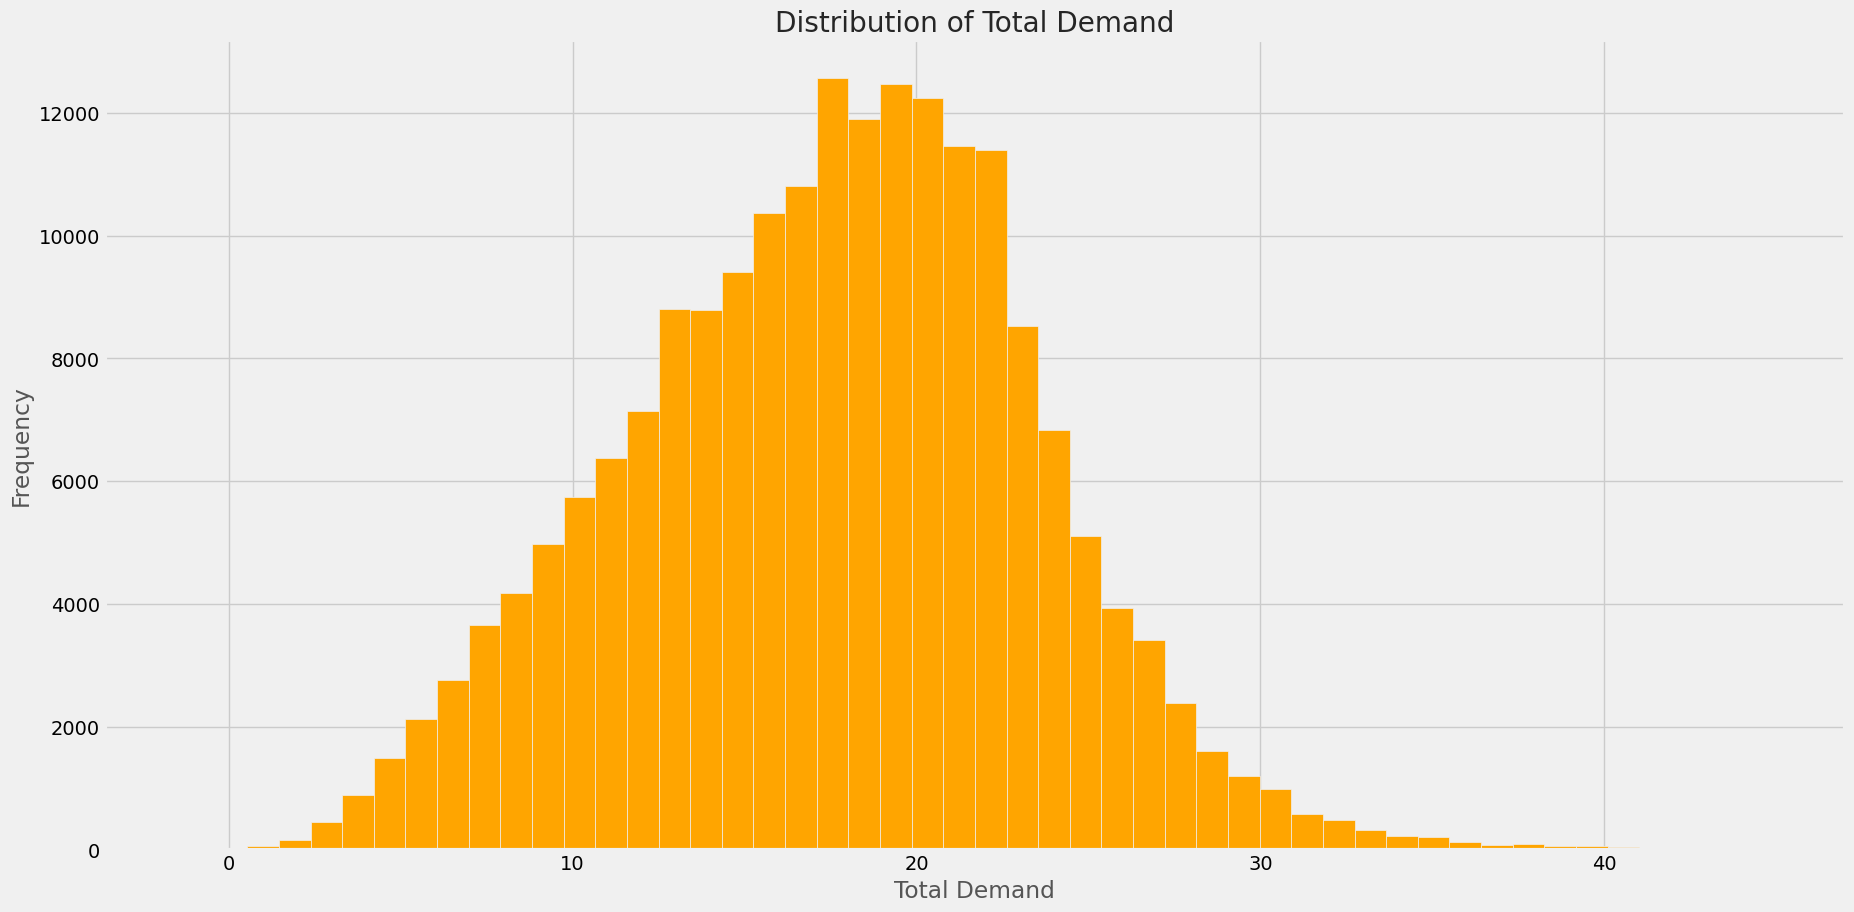

In [34]:
nsw_df['TEMPERATURE'].hist(bins=50, color='orange')
plt.xlabel('Total Demand')
plt.ylabel('Frequency')
plt.title('Distribution of Total Demand')
plt.show()

# KDE of Total demand
to see the probability density of the total demand levels

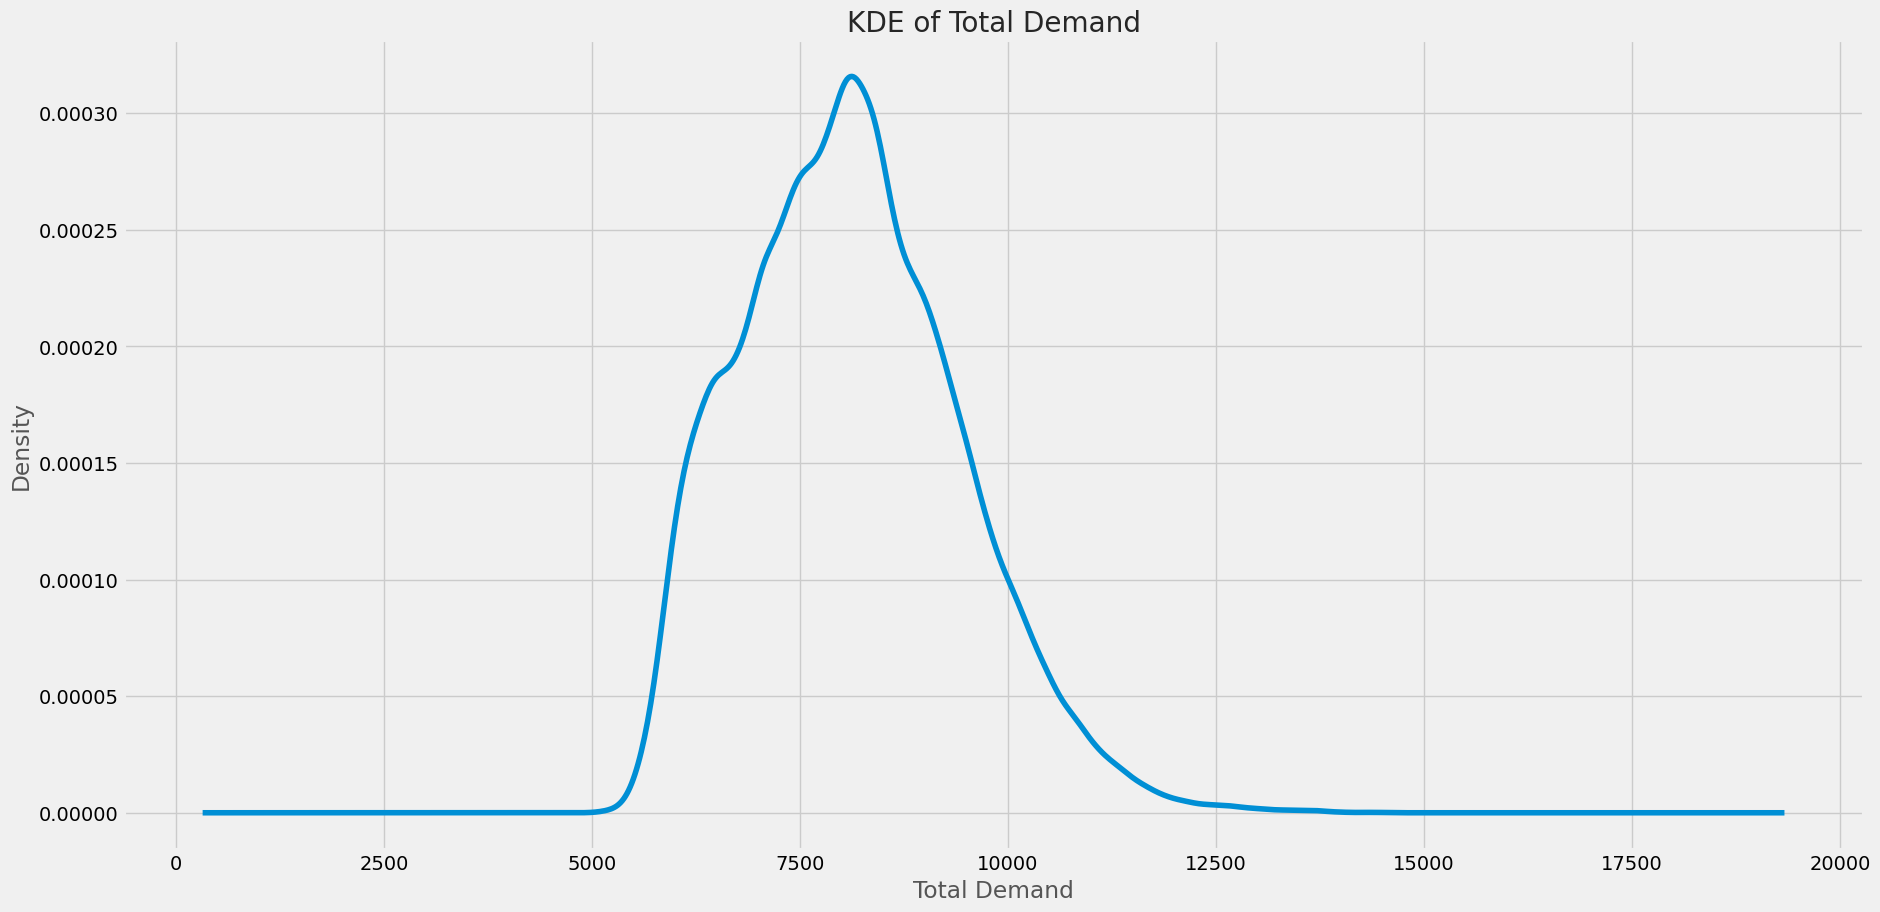

In [35]:
nsw_df['TOTALDEMAND'].plot(kind='kde')
plt.xlabel('Total Demand')
plt.title('KDE of Total Demand')
plt.savefig(os.path.join(CFG.images_path, 'total demand vs time of day.png'))
plt.show()

# Autocorrelation plot

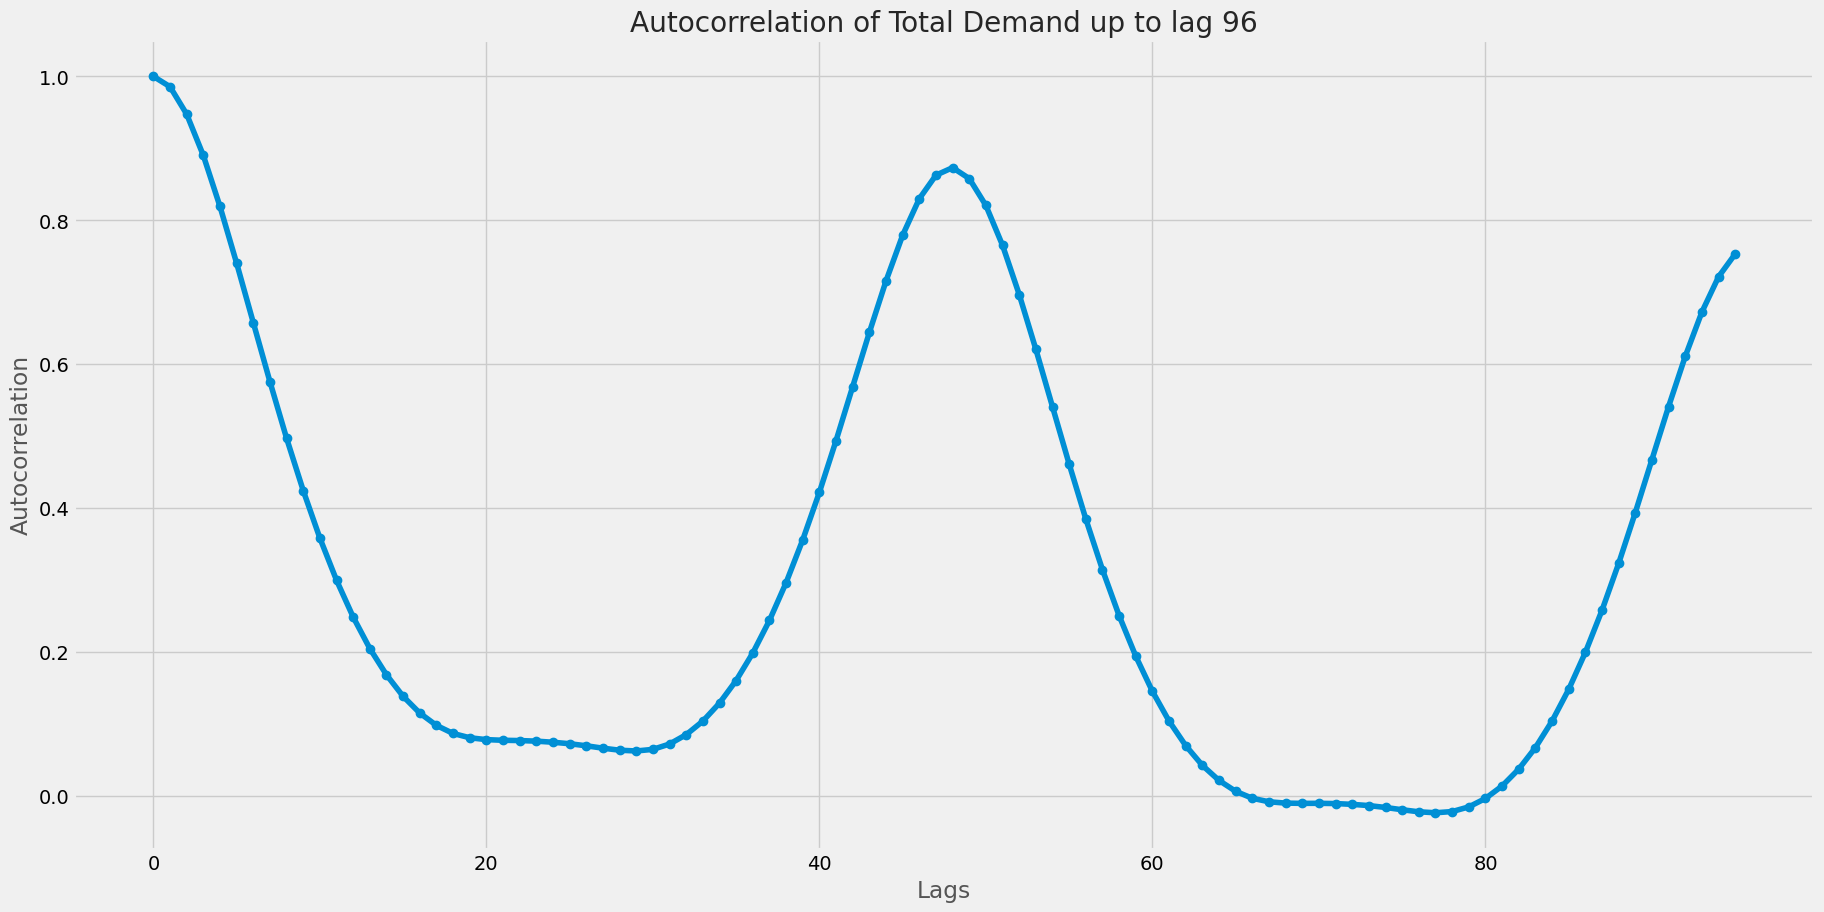

In [36]:
max_lags = 96
autocorrelation_values = [nsw_df['TOTALDEMAND'].autocorr(lag=i) for i in range(max_lags)]
plt.plot(autocorrelation_values, marker='o')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation of Total Demand up to lag {}'.format(max_lags))
plt.savefig(os.path.join(CFG.images_path, 'total demand vs time of day.png'))
plt.show()

## Observations
For half-hourly data, 96 lags represent a full two days. From the autocorrelation plot, we can make some key interpretations:

1. **High Initial Autocorrelation**: The autocorrelation starts at 1 (as it must, since this represents correlation with itself at lag 0) and remains high over the initial lags, which suggests that the demand data is strongly influenced by its immediate past values. This could be due to consistent patterns of demand across adjacent time intervals.

2. **Daily Seasonality**: The peak in autocorrelation at lag 48 (which represents a full day's lag for half-hourly data) indicates a strong daily seasonal pattern. The demand at the same time on one day is highly correlated with the demand at the same time on the next day.

3. **Two-Day Cycle**: The second peak at lag 96 shows that the demand also correlates with itself two days apart. This reinforces the daily seasonality and suggests a stable pattern of demand that repeats every 48 half-hour period.

4. **Troughs at Intermediate Lags**: The troughs at lags that are halfway between the peaks (around 24 and 72) may suggest a less significant correlation at these intermediate points. This could be due to the contrast between daytime and nighttime demand or the differences in demand patterns between workdays and non-workdays.

This autocorrelation structure indicates that any models for forecasting or analysis should account for daily seasonality. Time series models such as ARIMA with seasonal components or machine learning models with lagged features might be well-suited to capture and predict these patterns.

# Seasonality of Temperature

In [37]:
# Uses nsw_df.parquet as base file for data
# Uses functions temperature_plot() and polar_plot()
# Creates & deletes a dataframe called 'df_eda_temperature' (avoid using this name elsewhere)

In [38]:
c_map = {'Summer':'red', 'Autumn':'brown', 'Winter':'blue', 'Spring':'orange'}
df_eda_temperature = nsw_df
df_eda_temperature['season_name'] = df_eda_temperature['month'].map(lambda m: 'Summer' if m in [1, 2, 12] else ('Autumn' if m in [3, 4, 5] else ('Winter' if m in [6, 7, 8] else 'Spring'))).astype('category')

In [39]:
temperature_plot(df=df_eda_temperature.iloc[::96, :], roll=0, var_name='TEMPERATURE', size=(8,5))
temperature_plot(df=df_eda_temperature.loc['2012':'2013'].iloc[::10, :], roll=0, var_name='TEMPERATURE', highlight=['2012-03','2012-05'], title='Yearly',size=(8,5))
temperature_plot(df=df_eda_temperature.loc['2012-3':'2012-4'].iloc[::12, :], roll=0, var_name='TEMPERATURE', highlight=['2012-03-05','2012-03-07'], title='Monthly', size=(8,5))
temperature_plot(df=df_eda_temperature.loc['2012-4-5':'2012-4-6'], roll=0, var_name='TEMPERATURE', highlight=0, title='Daily', size=(8,5))

NameError: name 'temperature_plot' is not defined

In [ ]:
# fix_me

In [ ]:
def polar_plot(df=nsw_df, r='TEMPERATURE', t='month', c='year', title='Yearly'):
    fig = px.line_polar(df, r=r, theta=t, color=c, line_close=True, 
                        color_discrete_sequence=px.colors.sequential.Plasma_r,
                        template="plotly")
    fig.add_annotation(x=0.5, y=0.55, text='Temperature (°C)', showarrow=False, font=dict(size=10, color='black')) #Adds temperature label
    fig.update_layout(title=f'{title} Seasonality of {r.title()}', title_x=0.5, polar=dict(radialaxis=dict(tickfont=dict(size=10))))
    
    fig.update_layout(legend=dict(x=0.92, y=0.91, traceorder='normal', font=dict(size=10))) #Move Legend
    fig.update_layout(width=800, height=600)    
    return fig

In [ ]:
df_eda_temperature = nsw_df.groupby(pd.Grouper(freq='ME'), dropna=False).mean() #Monthly Aggregation
df_eda_temperature['year'] = df_eda_temperature.index.year.astype('category')
df_eda_temperature['monthName']= df_eda_temperature.index.month_name().str[:3].astype('category')
df_eda_temperature = df_eda_temperature.loc[(df_eda_temperature.index.year % 2 == 0)] #2010-2020 only even years
polar_plot(df=df_eda_temperature, r='TEMPERATURE', t='monthName', c='year', title='(a) Yearly')

# Total Demand Lag plots

In [ ]:
def lag_plot(df=nsw_df, var_name='TOTALDEMAND', hue='season', lag=1, color_map='viridis', legend_title='legend'):
    # Generates a scatterplot lag plot
    
    # Main Scatter Plot
    for group in df[hue].unique():
        df_grouped = df[df[hue] == group]
        plt.scatter(df_grouped[var_name], df_grouped.shift(lag)[var_name], c=color_map[group], s=20, alpha=0.7)
    
    # Legend
    plt.legend(title=legend_title.title(), loc='lower right', frameon=True, labels=df[hue].unique())
        
    # Labelling Axis / Title
    plt.grid(True) #Grid
    plt.xlabel(f'{var_name.title()}(i)')
    plt.ylabel(f'{var_name.title()}(i+{str(lag)})')
    # plt.title(f'Lag {lag} Plot: {var_name.title()}(i) vs {var_name.title()}(i+{str(lag)})')
    plt.title(f'Lag {lag} Plot: Relationship of lagged version of {var_name.title()}')
    
    # Axis Limits   
    plt.xlim(min(df[var_name].min(), df.shift(lag)[var_name].min()), max(df[var_name].max(), df.shift(lag)[var_name].max()))
    plt.ylim(min(df[var_name].min(), df.shift(lag)[var_name].min()), max(df[var_name].max(), df.shift(lag)[var_name].max()))
    
    # Correlation Value Display
    plt.text(df[var_name].min() + 0.08 * df[var_name].min(), df[var_name].max() - 0.08 * df[var_name].max(),
             f'r={df[var_name].corr(df.shift(lag)[var_name]):.2f}', va='top', ha='left', fontsize=15,
             bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))
    
    # Adding line Y=X
    plt.axline((0, 0), slope=1, color='black', linestyle='--')
    return None

In [ ]:
# setting up Colour Map and season_name column for nsw_df
c_map = {
    'Summer':'red', 
    'Autumn':'brown', 
    'Winter':'blue', 
    'Spring':'orange'
}

nsw_df['season_name'] = nsw_df['month'].map(lambda m: 'Summer' if m in [1, 2, 12] else ('Autumn' if m in [3, 4, 5] else ('Winter' if m in [6, 7, 8] else 'Spring'))).astype('category')

In [ ]:
lag_plot(
    df=nsw_df, 
    var_name='TOTALDEMAND', 
    hue='season_name', 
    lag=1, 
    color_map=c_map, 
    legend_title='season'
)

In [ ]:
lag_plot(
    df=nsw_df, 
    var_name='TOTALDEMAND', 
    hue='season_name', 
    lag=2, 
    color_map=c_map, 
    legend_title='season'
)

In [ ]:
lag_plot(
    df=nsw_df, 
    var_name='TOTALDEMAND', 
    hue='season_name', 
    lag=3, 
    color_map=c_map, 
    legend_title='season'
)

In [ ]:
lag_plot(
    df=nsw_df, 
    var_name='TOTALDEMAND', 
    hue='season_name', 
    lag=4, 
    color_map=c_map, 
    legend_title='season'
)

# Decomposition

In [ ]:
res = seasonal_decompose(
    nsw_df['TOTALDEMAND'], 
    model='additive', 
    period=48
)

res.plot()

# Decomposition of 1 year of data

In [ ]:
one_year_data = nsw_df.loc['2020']

res_one_year = seasonal_decompose(
    one_year_data['TOTALDEMAND'], 
    model='additive', 
    period=48
)

res_one_year.plot()

### decompose for one week

In [ ]:
one_week_data = nsw_df['2020-01-01': '2020-01-07']

res_one_week = seasonal_decompose(
    one_week_data['TOTALDEMAND'], 
    model='additive', 
    period=48
)

res_one_week.plot()

### Decompose for 2 days

In [ ]:
one_day_data = nsw_df['2020-01-01 00:00:00': '2020-01-02 23:30:00']

res_one_day = seasonal_decompose(
    one_day_data['TOTALDEMAND'], 
    model='additive',
    period=48
)

res_one_day.plot()

# Autocorrelation analysis (ACF and PACF)

In [ ]:
tsa.plot_acf(nsw_df['TOTALDEMAND'])
plt.show()

Here's what we can interpret from the ACF plot to inform the sequence length for an LSTM:
- **Significant Lags**: The plot shows peaks at regular intervals, which suggests seasonality in the data. These significant lags indicate that the data points are correlated with their past values at these intervals.
- **Seasonality Intervals**: The distances between the peaks can help identify the seasonality interval. In the context of sequence length for an LSTM, you might want to ensure that the sequence length covers at least one full seasonal cycle to capture the seasonality pattern.
- **Decay of Correlation**: The strength of the correlation generally seems to decay as the lag increases, but there is a repeating pattern of rising and falling, which is typical in time series with seasonal effects.
- **Cut-off Point**: There isn't a clear cut-off point where the correlation drops to near zero, which suggests the influence of past values might extend quite far back. This could imply that a longer sequence might be beneficial for the LSTM to learn from.
- **Practical Considerations**: While the ACF plot suggests that data is seasonally correlated over several lags, practical constraints such as the availability of data, computational power, and the risk of overfitting with very long sequences should also be considered.
- **Optimal Sequence Length**: The optimal sequence length would likely be a multiple of the seasonality interval identified from the plot, ensuring that at least one, or possibly multiple, full seasonal patterns are included within each sequence.

In [ ]:
tsa.plot_pacf(nsw_df['TOTALDEMAND'])
plt.show()

# Observations
The Partial Autocorrelation Function (PACF) plot provides insight into the relationship between a time series and its lags after removing the effects of earlier lags. It's helpful for identifying the order of an autoregressive (AR) process.

From the PACF plot you've provided, we observe a few things:

- There is a significant spike at lag 1, which quickly diminishes after lag 2 and stays within what would typically be the confidence interval (not shown on this plot but usually at around +/- 0.2 for large datasets).
- Beyond the initial lags, most of the partial autocorrelations appear to be insignificant, as they are relatively small in magnitude and seem to be within the expected range of random fluctuation.
- The spikes that do occur at later lags appear somewhat sporadic and do not show a clear repeating pattern that would indicate seasonality.

This pattern suggests that the time series may be well modeled by an AR process of order 1 or possibly 2, since the partial autocorrelation is significant at lag 1 and possibly at lag 2. After these initial lags, the partial autocorrelations are not consistently significant, which indicates that incorporating additional lags into the model may not provide additional value.

In [ ]:
nsw_df

# Temperature scatter plot

In [ ]:
temp_df = nsw_df[['TEMPERATURE', 'month', 'season']]

In [ ]:
plt.figure(figsize=(CFG.img_dim1, CFG.img_dim2))
sns.scatterplot(data=temp_df, x=temp_df.index, y='TEMPERATURE', hue='season')
plt.title('Temperature Scatter Plot')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.show()

### Observations
...

# Box plot of Temperature by Season

In [ ]:
plt.figure(figsize=(CFG.img_dim1, CFG.img_dim2))
sns.boxplot(data=temp_df, x='season', y='TEMPERATURE', hue='season')
plt.show()

### Observations
...

In [ ]:
temp_highest_allowed = round(temp_df['TEMPERATURE'].mean() + 3 * temp_df['TEMPERATURE'].std(), 2)
temp_lowest_allowed = round(temp_df['TEMPERATURE'].mean() - 3 * temp_df['TEMPERATURE'].std(), 2)
print('Highest Allowed:', temp_highest_allowed)
print('Lowest Allowed:', temp_lowest_allowed)

In [ ]:
temp_outliers = temp_df[(temp_df['TEMPERATURE'] > temp_highest_allowed) | (temp_df['TEMPERATURE'] < temp_lowest_allowed)]
print('Total Rows:', len(temp_outliers))

In [ ]:
sns.scatterplot(data=temp_outliers, x=temp_outliers.index, y='TEMPERATURE', hue='season')
plt.title('Temperature Outliers ScatterPlot')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.show()

In [ ]:
high_outliers = temp_outliers.loc[temp_outliers['TEMPERATURE'] > temp_highest_allowed]
t_high_df = high_outliers['month'].value_counts()
t_high_df = t_high_df.reset_index()
t_high_df.columns = ['Month', 'Count']
t_high_df_sorted = t_high_df.sort_values(by='Month', ascending=True)
print(t_high_df_sorted)

In [ ]:
# histogram
sns.barplot(data=t_high_df_sorted, x='Month', y='Count')
plt.title('Distribution of High Temperature Outliers')
plt.show()

In [ ]:
low_outliers = temp_outliers.loc[temp_outliers['TEMPERATURE'] < temp_lowest_allowed]
t_low_df = low_outliers['month'].value_counts()
t_low_df = t_low_df.reset_index()
t_low_df.columns = ['Month','Count']
t_low_df_sorted = t_low_df.sort_values(by='Month', ascending=True)
print(t_low_df_sorted)

In [ ]:
# Histogram
plt.figure(figsize=(CFG.img_dim1, CFG.img_dim2))
sns.barplot(data=t_low_df, x='Month', y='Count')
plt.title('Distribution of Low Temperature Outliers')
plt.show()

In [ ]:
price_outlier_df = nsw_df[['rrp', 'month', 'season']]

In [ ]:
plt.figure(figsize=(CFG.img_dim1, CFG.img_dim2))
sns.scatterplot(data=price_outlier_df, x=price_outlier_df.index, y='rrp', hue='season')
plt.title('Price ScatterPlot')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

In [ ]:
nsw_df.head()

In [ ]:
price_highest_allowed = round(price_outlier_df['rrp'].mean() + 3 * price_outlier_df['rrp'].std(), 2)
price_lowest_allowed = round(price_outlier_df['rrp'].mean() - 3 * price_outlier_df['rrp'].std(), 2)

In [ ]:
price_outliers = price_outlier_df[(price_outlier_df['rrp']>price_highest_allowed) | (price_outlier_df['rrp']<price_lowest_allowed)]
print(len(price_outliers))

In [ ]:
sns.scatterplot(data=price_outliers,x='month', y='rrp', hue='season')
plt.title('Scatterplot of Price by Month')
plt.legend()
plt.show()

In [ ]:
# low_outliers = temp_outliers.loc[temp_outliers['TEMPERATURE']<temp_lowest_allowed]
price_out_df = price_outliers['month'].value_counts()
price_out_df = price_out_df.reset_index()
price_out_df.columns = ['Month', 'Count']
price_out_df_sorted = price_out_df.sort_values(by='Month', ascending=True)
# print(price_out_df_sorted)

In [ ]:
# histogram
plt.figure(figsize=(CFG.img_dim1, CFG.img_dim2))
sns.barplot(data=price_out_df_sorted, x='Month', y='Count')
plt.title('Distribution of Price Outliers')
plt.show()

In [ ]:
total_demand_highest_allowed = round(nsw_df['TOTALDEMAND'].mean() + 3 * nsw_df['TOTALDEMAND'].std(), 2)
total_demand_lowest_allowed = round(nsw_df['TOTALDEMAND'].mean() - 3 * nsw_df['TOTALDEMAND'].std(), 2)
print(total_demand_highest_allowed)
print(total_demand_lowest_allowed)

In [ ]:
total_demand_outliers = nsw_df[(nsw_df['TOTALDEMAND'] > total_demand_highest_allowed) | (nsw_df['TOTALDEMAND'] < total_demand_lowest_allowed)]
print(len(total_demand_outliers))

In [ ]:
plt.scatter(
    total_demand_outliers.index, 
    total_demand_outliers['TOTALDEMAND'], 
    c=total_demand_outliers['month']
)
plt.legend()
plt.show()

In [ ]:
print(total_demand_outliers['month'].value_counts())

In [ ]:
lag_test = nsw_df['TEMPERATURE'].shift(2)
lag_test

In [ ]:
varShifted = nsw_df['TEMPERATURE'].shift(2)
varShifted = varShifted.interpolate(
    method='linear', 
    limit_direction='both', 
    axis=0
)
varShifted

# Kalman Filter
Smoothing the input data helps to reduce the impact of random noise in the data and produce a more stable estimate of the underlying trend, which can lead to more accurate and reliable estimates of the system's state.

In [ ]:
from pykalman import KalmanFilter
test = nsw_df['TOTALDEMAND']

# construct a Kalman filter
kf = KalmanFilter(transition_matrices = [1],
    observation_matrices = [1],
    initial_state_mean = 0,
    initial_state_covariance = 1,
    observation_covariance=1,
    transition_covariance=.01
    )
# use the observed values of the price to get a rolling mean
state_means, _ = kf.filter(test.values)
state_means = pd.Series(state_means.flatten(), index=test.index)

nsw_df['TOTALDEMAND'].plot(alpha=0.5, label='Real Demand Data')
state_means.plot(label='Kalman Smoothed')
plt.legend()

In [ ]:
nsw_df.head()